In [101]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets
import torchvision.transforms as transforms
import torch.utils.data as data
from torchvision import models

import matplotlib.pyplot as plt
import random
from collections import OrderedDict

# Loading and preparing the Data

### Run the Next cell after download the [Data](https://www.kaggle.com/competitions/dogs-vs-cats/data) and add the zip file to the this notebook location to prepare the data
##### The next cell may take up to 2 minutes

In [102]:
#%run Prepare.py

In [103]:
train_transform = transforms.Compose([transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

test_transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    ])

# Load the data
dataset = datasets.ImageFolder(root='train', transform=train_transform)
test_data = datasets.ImageFolder(root='test1', transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

### We won't be able to test the model using the test data because we don't have the actual labels of the images, so we will split the train data to train and test data

In [104]:
val_size = 0.15

# calculate the size of the validation set and the training set
val_len = int(len(dataset) * val_size)
train_len = len(dataset) - val_len

# use random_split to split the dataset into training and validation sets
train_set, val_set = data.random_split(dataset, [train_len, val_len])

# create data loaders for the training and validation sets
train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False)

## Let's view Random image

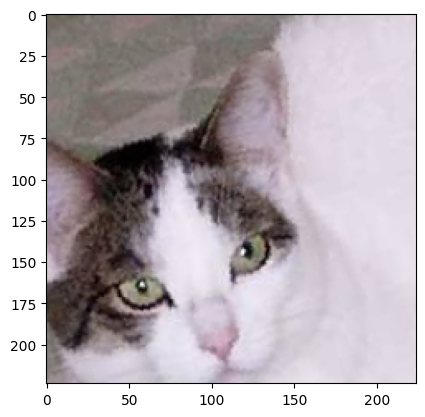

In [108]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

n = random.randint(1,30)
# Plot the first image in the batch
plt.imshow(images[n].permute(1, 2, 0))
plt.show()

# Loading the model and Training

## Loading

In [109]:
model = models.densenet121(pretrained=True)
model

c:\Program Files\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

#### This model have been trained on imageNet dataset so we will keep the feature part since it will help in feature extraction and we will rebuild and train the Classifier part to satisfy or classes

In [110]:
# Freezing the feature parameters
for parm in model.parameters():
    parm.requires_grad = False


# The expected input size of the classifier should be 1024
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1024, 512)),
    ('relu1', nn.ReLU()),
    ("Drop", nn.Dropout(p=.2)),
    ('fc2', nn.Linear(512, 2)),
    ('output', nn.LogSoftmax(dim=1))
]))

In [111]:
model.classifier = classifier
model = model.cuda()

In [112]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.002)

## Training

In [113]:
epochs = 5
model.train()
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        labels = labels.cuda()
        images = images.cuda()
        
        output = model.forward(images)
        optimizer.zero_grad()
        
        loss = criterion(output, labels)
        running_loss+= loss
        
        loss.backward()
        optimizer.step()

    print(f"Loss for epoch {e} is {running_loss / len(train_loader)}")

Loss for epoch 0 is 0.2112964689731598
Loss for epoch 1 is 0.172276571393013
Loss for epoch 2 is 0.1677951216697693
Loss for epoch 3 is 0.1586681604385376
Loss for epoch 4 is 0.15984098613262177


# TESTING

In [118]:
# Testing the model 
model.eval()
accuracy = 0
for images, labels in val_loader:
    images, labels = images.cuda(), labels.cuda()
    
    logps = model(images)
    prop = torch.exp(logps)
    
    _, top_class = prop.topk(1, dim=1)
    equality = top_class == labels.view(*top_class.shape)
    
    accuracy += torch.mean(equality.type(torch.FloatTensor)).item()
accuracy /= len(val_loader)
accuracy *= 100    

In [119]:
print(f"Model accuracy in test data is : {accuracy:.2f}%")

Model accuracy in test data is : 93.88%


### Let's Visual Some images and see Model predations

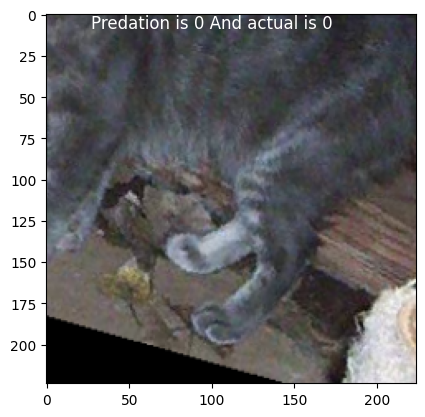

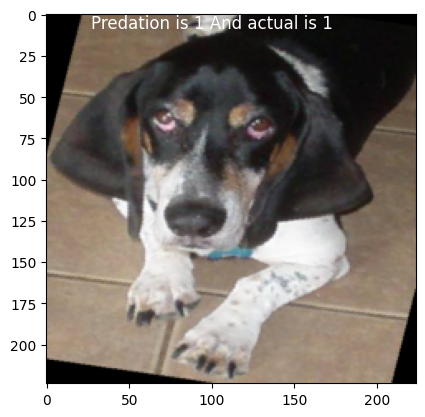

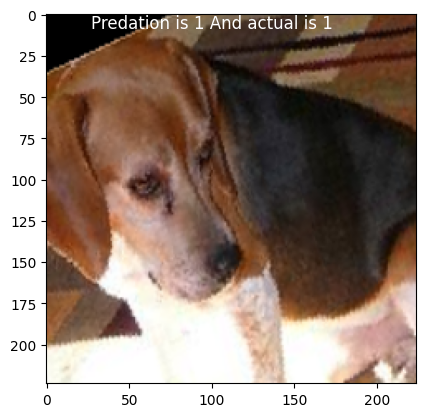

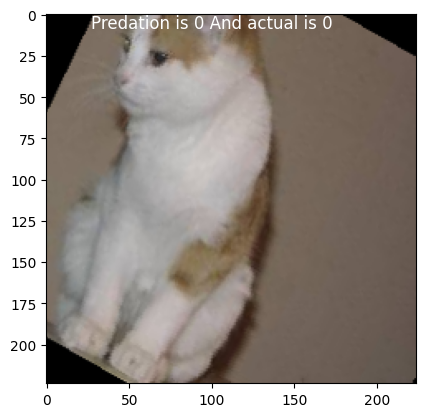

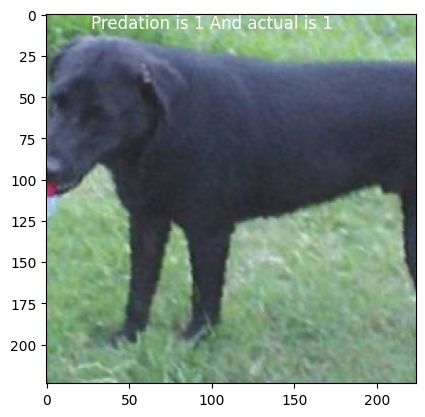

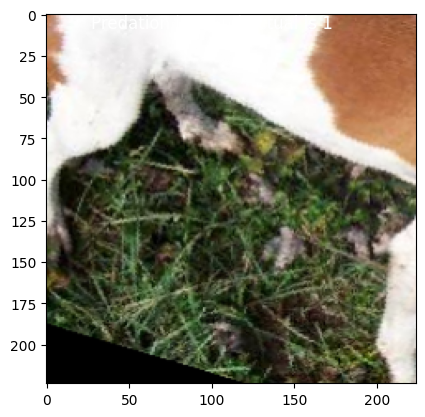

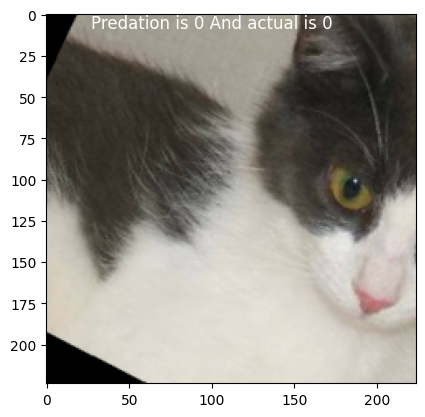

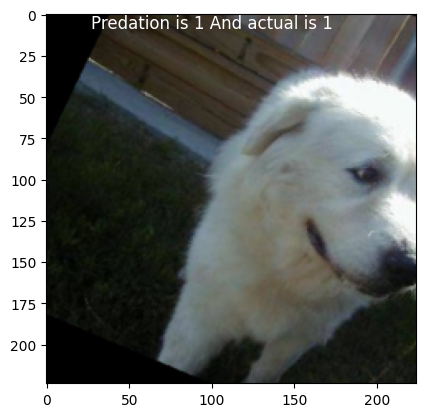

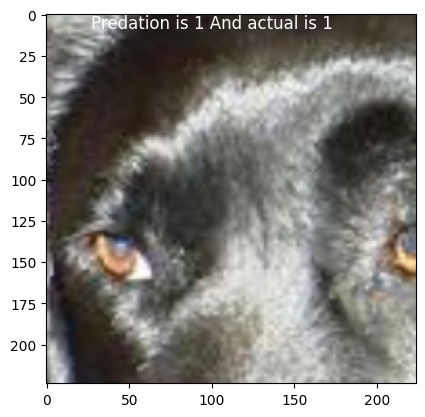

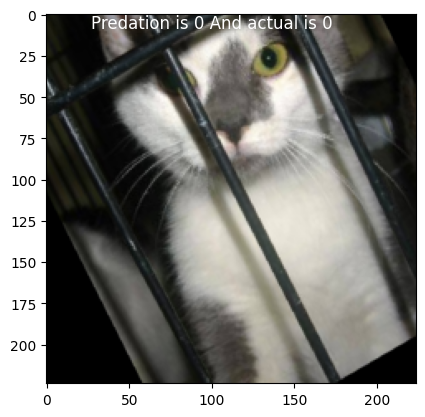

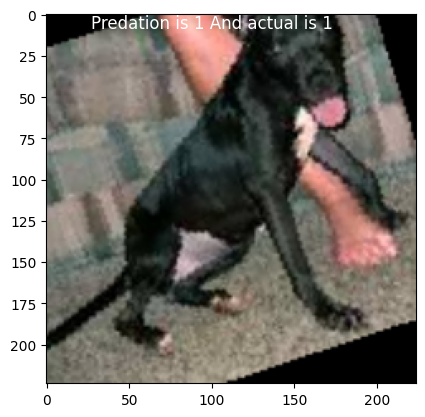

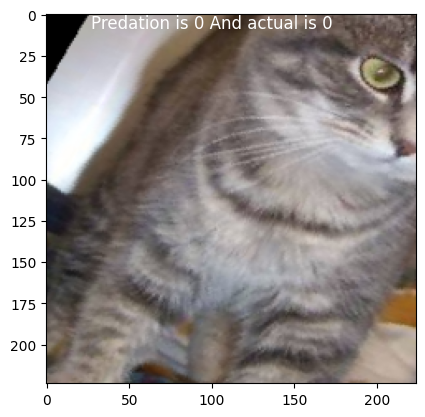

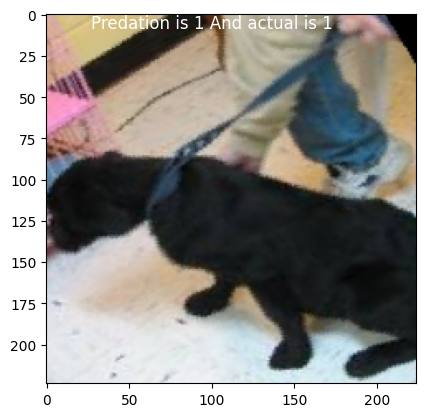

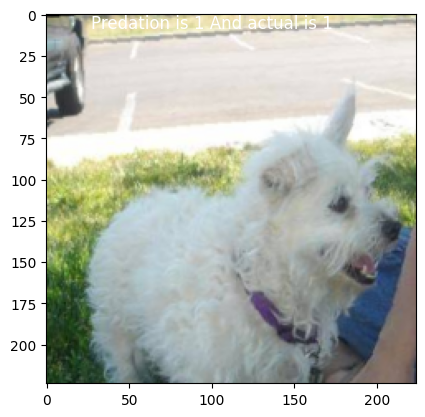

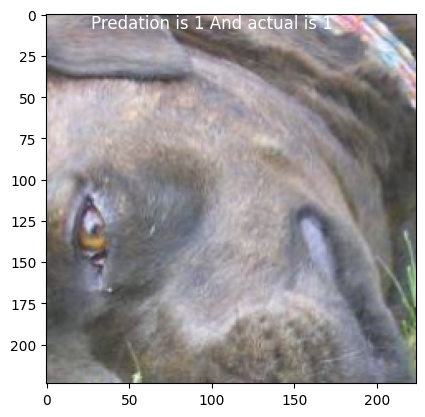

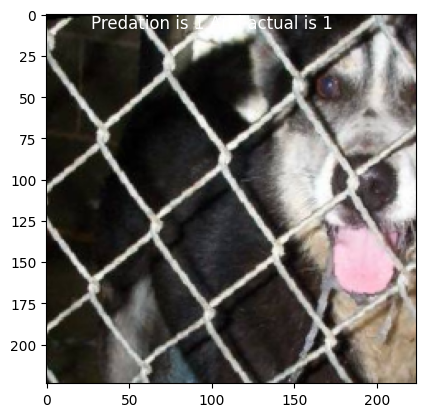

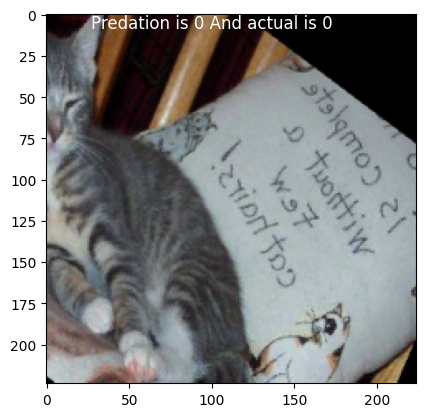

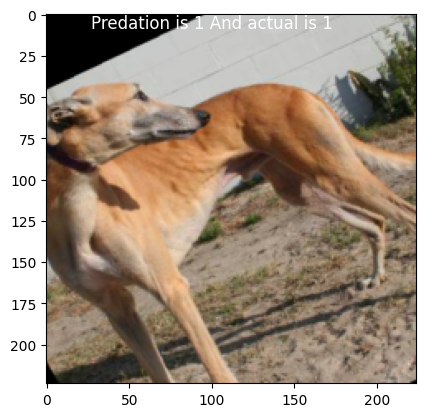

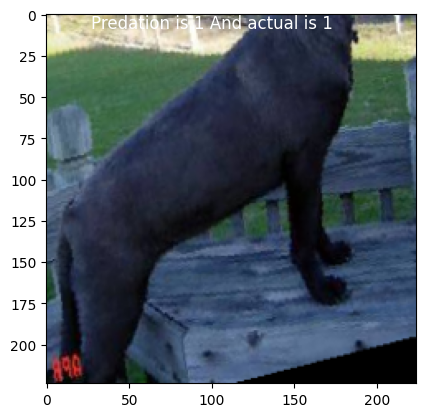

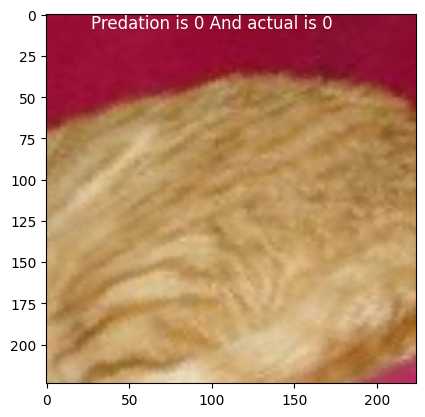

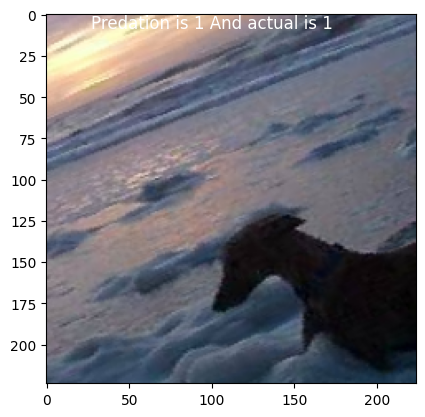

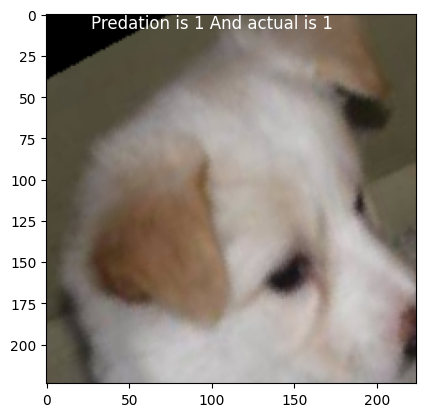

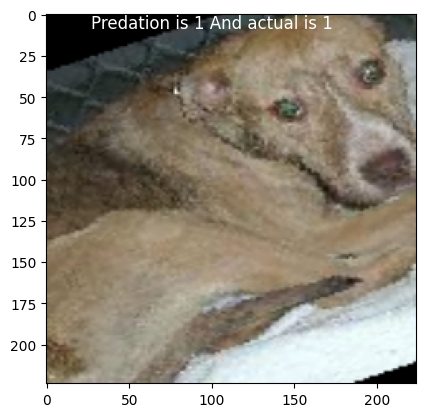

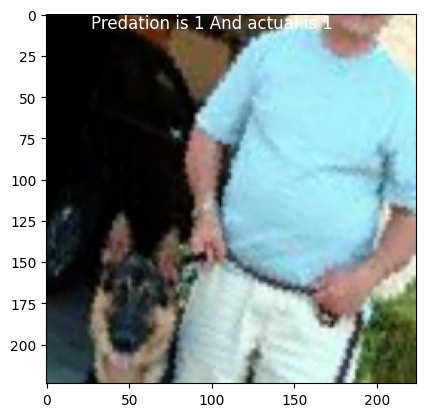

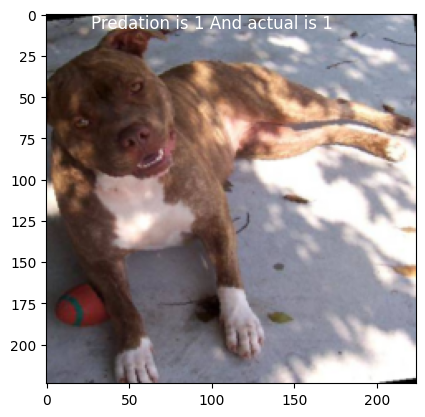

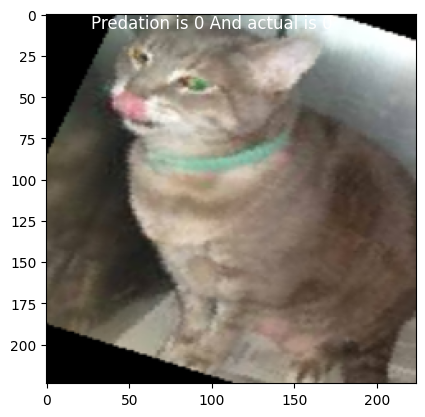

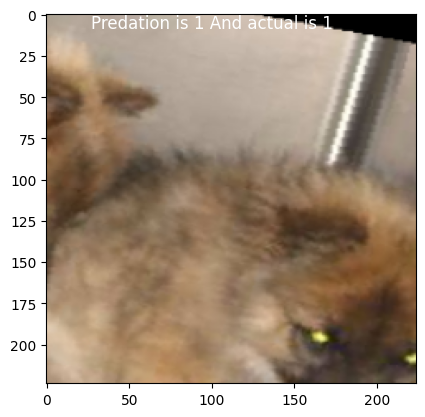

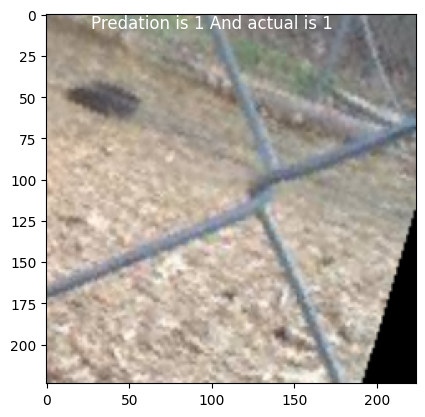

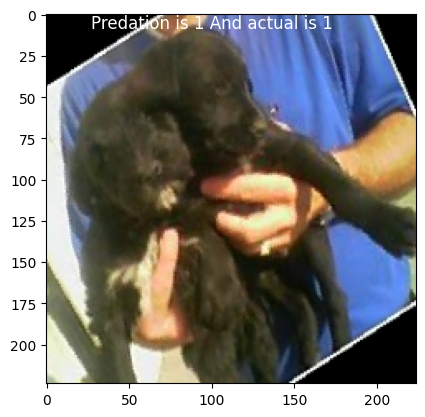

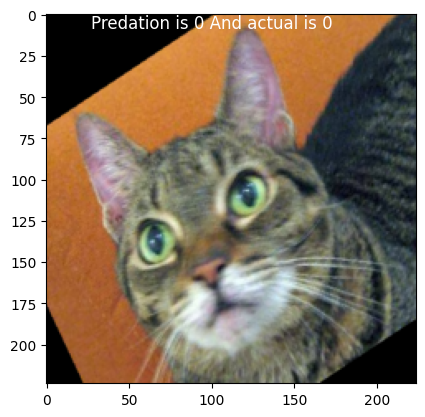

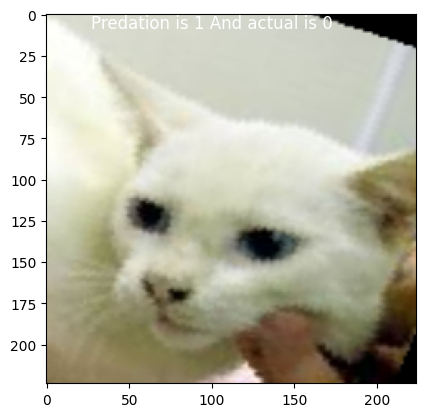

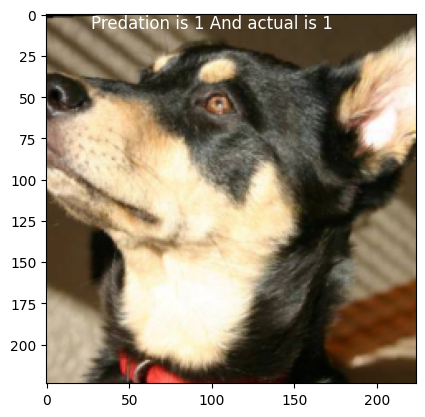

In [126]:
for images, labels in val_loader:
    images, labels = images.cuda(), labels.cuda()
    
    logs = model(images)
    prop = torch.exp(logs)
    
    for img, actual_label, predicted_label in zip(images, labels,prop ):
        img = img.cpu()
        plt.imshow(img.permute(1,2,0))
        
        predicted_label = torch.argmax(predicted_label)
        predicted_label = str(predicted_label.item())

        actual_label = str(actual_label.item())
        
        show = f"Predation is {predicted_label} And actual is {actual_label}"
        plt.text(100, 5, show, color="White", fontsize=12, ha="center", va="center")
        plt.show()
    break